# CDA (Confirmatory Data Analysis)

In this notebook, we explore some models hypothesized to be useful based on our earlier EDA. There are two initial models we try here before exploring others. Note that our models are strictly SARIMA++ models. It is similar to SSARIMA in being able to model multiple seasonalities, see (https://cran.r-project.org/web/packages/smooth/vignettes/ssarima.html), however we have not investigated their mathematics and made a comparison. 

A justification for using SARIMA++ for our dataset is perhaps due to the fact that the patterns of the time series appears to be more stochastic than deterministic. We do not study other models, although we would have liked to have attemped the Holt-Winters model as a second model by which we can forecast using the average of the H-W and SARIMA++ models.

Forecasting results are presented after chosing an appropriate SARIMA++ model.

Note that the graphs are (more) readable when plotting via widgets, i.e. changing **'%matplotlib notebook'** to **'%matplotlib tk'** and then restarting the kernel (and re-running everything). Note, however the dataset required is not found within this directory and needs to be downloaded at: (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783)

## Preliminaries (imports and function definitions)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as stt
from scipy.stats import gaussian_kde, norm
from sklearn.neighbors import KernelDensity
from sympy import poly
from sympy.abc import a, b, B, c, d

from incidents_police_dep_eda_jup import compute_rks3, compute_safe_conf_95

# for jupyter
import sys
sys.path.append('..')

import time_series_funcs.sarima_plus_plus as spp

%matplotlib notebook

In [2]:
def create_residuals_subplots(ts, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=100, ):
    # plots the residuals, the first-lag autocorr, and the first-lag partial autocorr.

    # ts: time-series
    # p_poly: AR poly
    # q_poly: MA poly
    # d_poly: Difference poly
    # p_ARIMA_coeffs: coefficients of the p_poly
    # q_ARIMA_coeffs: coefficients of the q_poly
    # pacf_max: maximum pacf length

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    ts = ts.astype(float)

    if p_poly is not None:
        est_p_poly: poly = poly(p_poly.subs(dict(zip(p_symbols, p_ARIMA_coeffs))), B)
    else:
        est_p_poly = None
    if q_poly is not None:
        est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)
    else:
        est_q_poly = None

    print("est_p_poly:", est_p_poly)
    print("est_q_poly:", est_q_poly)

    # remember: use non-differenced series
    model_err = spp.calculateSeasonalARIMA_error(ts, est_p_poly, d_poly, est_q_poly)

    # step: differencing error, to test if if the noise term is describable by a MA(1) process

    model_err_sec = model_err[:-1] - model_err[1:]

    ax1.plot(model_err_sec, label='consec. differenced residuals')

    rks3 = compute_rks3(model_err_sec)
    res_95 = compute_safe_conf_95(rks3)
    ax2.plot(rks3, label='corellogram')
    ax2.vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:red")
    ax2.plot(res_95, label='est. upper 95% conf. interval, ')
    ax2.plot(-res_95, label='est. lower 95% conf. interval,')

    # remember: pacf calculation can be unstable. Lag_max is a function of convergence: the faster it converges,
    #  the smaller the pacf_max possible.
    ts_pacf = stt.pacf(rks3, nlags=pacf_max)
    ts_pacf_95 = np.sqrt(1 / len(rks3))

    ax3.plot(ts_pacf, label='pacf')
    ax3.plot([ts_pacf_95] * pacf_max, label='est. upper 95% conf. interval')
    ax3.plot([-ts_pacf_95] * pacf_max, label='est. lower 95% conf. interval')
    ax3.vlines(np.arange(0, len(ts_pacf)), 0, ts_pacf, color="tab:red")

    ax1.set_ylabel('Error')
    ax1.set_xlabel('t')
    ax1.legend()

    ax2.set_ylabel('Estimated corr. coeff.')
    ax2.set_xlabel('t')
    ax2.legend()

    ax3.set_ylabel('pacf.')
    ax3.set_xlabel('t')
    ax3.legend()

    return fig, (ax1, ax2, ax3)

## Start of Modelling

In [3]:
df = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
df = df.sort_values(by=['Incident Date'])

# Get only calls related to crime
temp_df = df[~df['Incident Category'].isin(['Non-Criminal'])]

# Sum up number of calls per day
crim_sum_df = temp_df.value_counts(['Incident Date']).reset_index(name='num_incidents').sort_values(
    by=['Incident Date'])

# Obtain time series of number of calls over a 2 year period
series_data = crim_sum_df['num_incidents'].to_numpy()

In [4]:
week = 7
month = 30
year = 365
cut_date = 70
total_series_length = 365 * 2 + cut_date  # warn: the cut date extends the ts enough for the 3rd-order models

# substep: remove intervention and yearly differencing
ts_cut = series_data[:total_series_length]
ts_cut_sec = ts_cut[:-1] - ts_cut[1:]
ts_cut_year = ts_cut[:-year] - ts_cut[year:]
ts_cut_week = ts_cut[:-week] - ts_cut[week:]
ts_cut_month = ts_cut[:-month] - ts_cut[month:]

# substep: Model 1 - Differencing: Weekly, and Consec
ts_cut_year_week = ts_cut_year[:-week] - ts_cut_year[week:]
ts_cut_year_week_sec = ts_cut_year_week[:-1] - ts_cut_year_week[1:]

# # substep: Model 2
ts_cut_year_week_month = ts_cut_year_week[:-month] - ts_cut_year_week[month:]
ts_cut_year_week_month_sec = ts_cut_year_week_month[:-1] - ts_cut_year_week_month[1:]

## Learning models

### Model 1 : Differencing(sec,weeky & yearly), SMA_7(1)xMA(1)

<IPython.core.display.Javascript object>


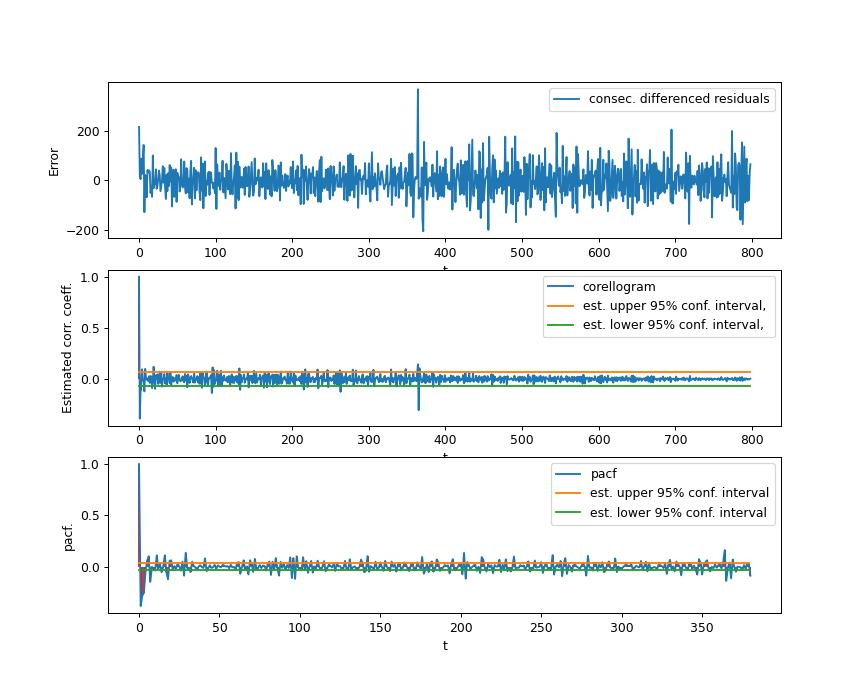

est_p_poly: None
est_q_poly: Poly(0.617462049764554*B**8 - 0.79975260014524*B**7 - 0.77206632357609*B + 1.0, B, domain='RR')


In [5]:
# AR backshift polynomial
p_poly = None 

# MA backshift polynomial
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B) 

# Differencing polynomial
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B ** 365, B) 

# parameters used in the polynomials above
p_symbols = []
q_symbols = [a, b]

res = spp.learn_model(ts_cut_year_week_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

# Plot time-series, autocorrelation, and partial autocorrelation (pacf).
create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=380)
plt.show()

Studying the autocorrelations of the differenced (1) residuals, the process is almost MA(1), with the first
lag a value of 0.4 (in contrast to a true MA(1) autocor. which has a value of 0.5
However, we now see a significant spike at lag 365, suggesting that the error is not truly white noise.
Perhaps an improvement to this model is to use another seasonal parameter - a moving average: SMA_365(0,1,1). Let us investigate this now.

### Model 1 + yearly param:  SMA_365(1)xSMA_7(1)xMA(1)

<IPython.core.display.Javascript object>


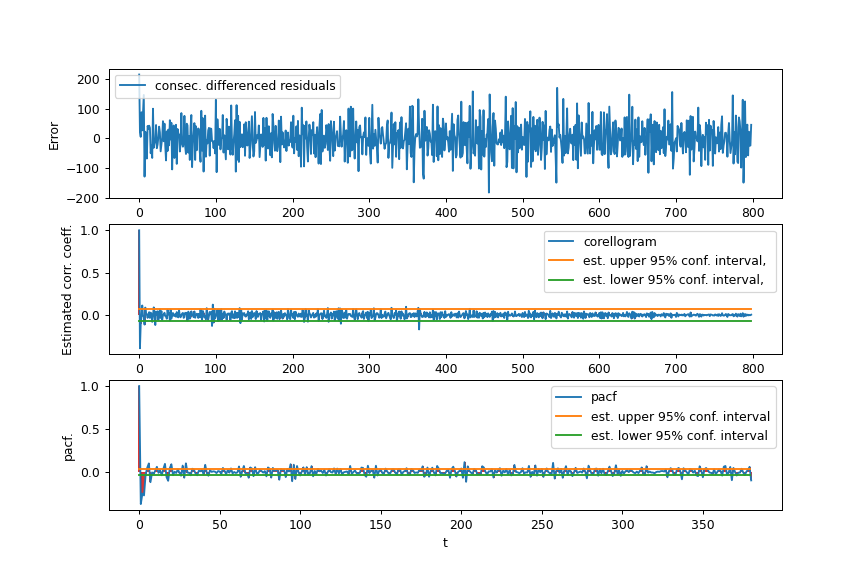

est_p_poly: None
est_q_poly: Poly(-0.301587285229303*B**373 + 0.390272686903183*B**372 + 0.380391980768858*B**366 - 0.492250859641551*B**365 + 0.612669900564346*B**8 - 0.79283292097727*B**7 - 0.772760419445185*B + 1.0, B, domain='RR')


In [6]:
p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B) * poly(1 - c * B ** 365, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B ** 365, B)

p_symbols = []
q_symbols = [a, b, c]

res = spp.learn_model(ts_cut_year_week_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=380)
plt.show()

The autocorrelation's 1st lag value is around 0.39, and now the 365th lag is muted. However, it is
not perfect. Let us look at what happens, if we instead choose to remove the yearly differencing
and the parameter therefore.

###  Model 1 w/o yearly differencing: SMA_7(1)xMA(1)


<IPython.core.display.Javascript object>


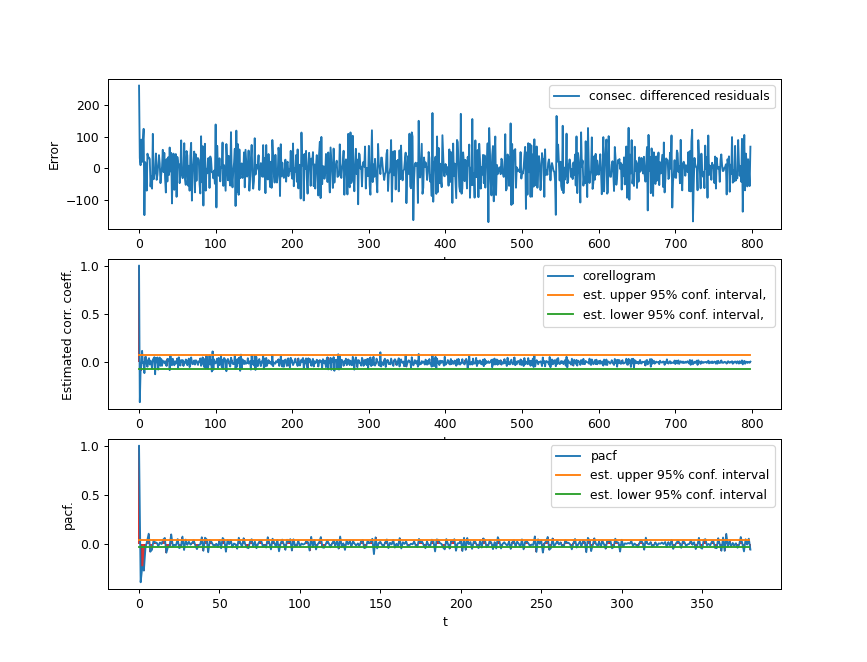

est_p_poly: None
est_q_poly: Poly(0.548104544135169*B**8 - 0.810051395359435*B**7 - 0.676629343860293*B + 1.0, B, domain='RR')


In [7]:
ts_cut_week_sec = ts_cut_week[:-1] - ts_cut_week[1:]

p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B)

p_symbols = []
q_symbols = [a, b]

res_main = spp.learn_model(ts_cut_week_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res_main.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=380)
plt.show()

We find the process almost an MA(1) having a 1st lag value of an 0.413  for the autocorr. There is no
spike for the 365th value. The autocorr. suggests this is a nicer, and perhaps more parsimonous result.
However, it may be argued that this is artefact due to our model using only two years.
If we had used many years, we might find the earlier model to be better.

The model above appears to have significant autocorr values on lag 4 (having value 0.118), and 7 (-0.0111). Let us see
if an extra weekly differencing can remove this.


### Model 1 w/o yr diff, and extra week diff: SMA_7(1)xMA(1)


<IPython.core.display.Javascript object>


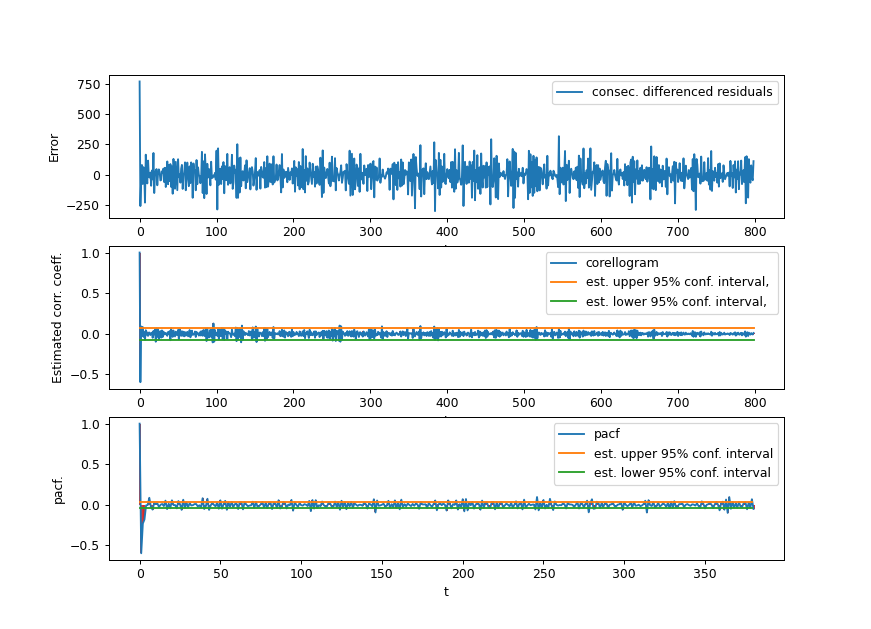

est_p_poly: None
est_q_poly: Poly(0.534730411421404*B**8 - 0.872873725020962*B**7 - 0.612609127865045*B + 1.0, B, domain='RR')


In [8]:
ts_cut_week_sec = ts_cut_week[:-1] - ts_cut_week[1:]
ts_cut_week2_sec = ts_cut_week_sec[:-week] - ts_cut_week_sec[week:]

p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B, B)

p_symbols = []
q_symbols = [a, b]

res = spp.learn_model(ts_cut_week2_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=380)
plt.show()

Almost an MA(1), but it has around 0.6 as the 1st lag of the autocorr., and the spikes
at 4,7 have been muted to values 0.085, -0.075 respectively. However, looking at the first lag,
it may be that this is over-differencing.

We now proceed to learning models with monthly differencing included.

### Model 2 (Differencing: sec,weeky,monthly & yearly), SMA_30(1)xSMA_7(1)xMA(1)


<IPython.core.display.Javascript object>


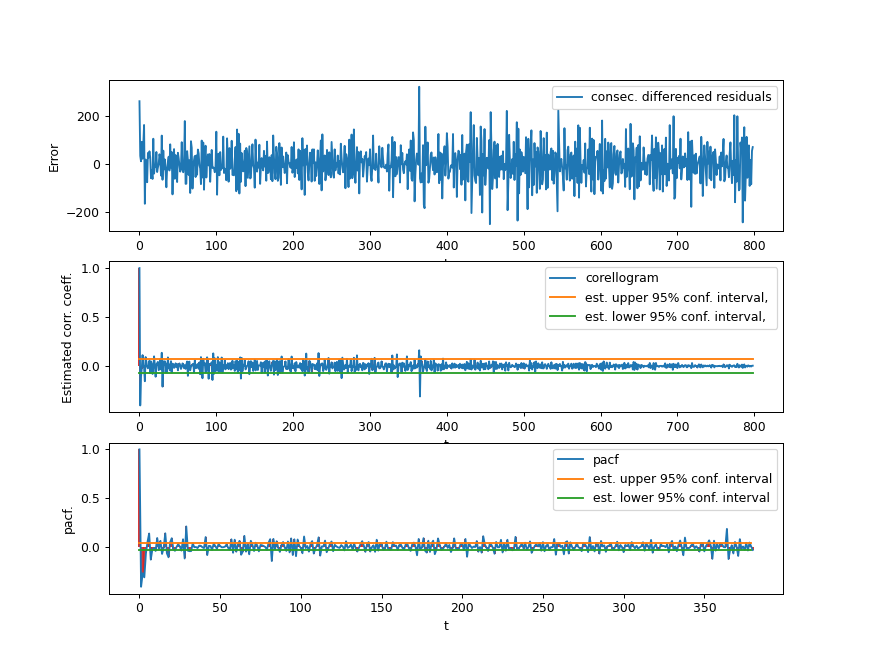

est_p_poly: None
est_q_poly: Poly(-0.353716969558499*B**38 + 0.521747705592765*B**37 + 0.48219934093312*B**31 - 0.711264715640369*B**30 + 0.497307066947696*B**8 - 0.733549259677563*B**7 - 0.677946382450567*B + 1.0, B, domain='RR')


In [9]:
p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B) * poly(1 - c * B ** 30, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B ** 365, B) * poly(1 - B ** 30, B)

p_symbols = []
q_symbols = [a, b, c]

res = spp.learn_model(ts_cut_year_week_month_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=380)
plt.show()

The process is not MA(1), since the autocorr. has spikes at lags 7,30,365. Let us remove the yearly differencing and see what happens.

### Model 2 w/o yr diff: SMA_30(1)xSMA_7(1)xMA(1)

<IPython.core.display.Javascript object>


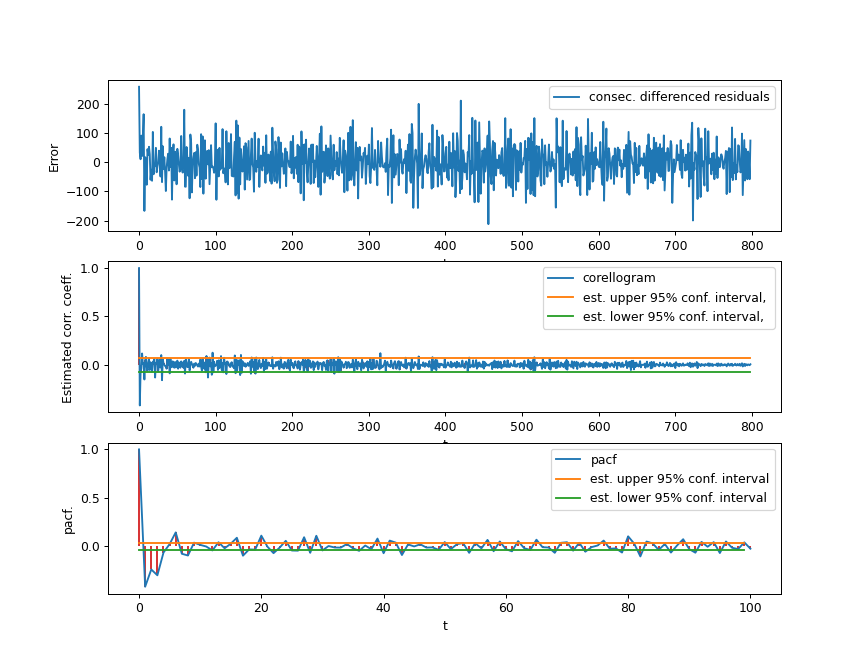

est_p_poly: None
est_q_poly: Poly(-0.350211073649942*B**38 + 0.512720981098543*B**37 + 0.480141750012831*B**31 - 0.702943931975782*B**30 + 0.498206268977379*B**8 - 0.729391005136677*B**7 - 0.68304416351285*B + 1.0, B, domain='RR')


In [10]:
ts_cut_month_week = ts_cut_month[:-week] - ts_cut_month[week:]
ts_cut_month_week_sec = ts_cut_month_week[:-1] - ts_cut_month_week[1:]

p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B) * poly(1 - c * B ** 30, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B ** 30, B)

p_symbols = []
q_symbols = [a, b, c]

res = spp.learn_model(ts_cut_month_week_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=100)
plt.show()

We find similar to before, the spike at the 365 lag removed. There are still spikes for the 7th and 30th lag however, but not too large.

Let us instead of removing the yearly difference, we introduce a yearly param.    

### Model 2 + yearly param:  SMA_365(1)xSMA_30(1)xSMA_7(1)xMA(1)

<IPython.core.display.Javascript object>


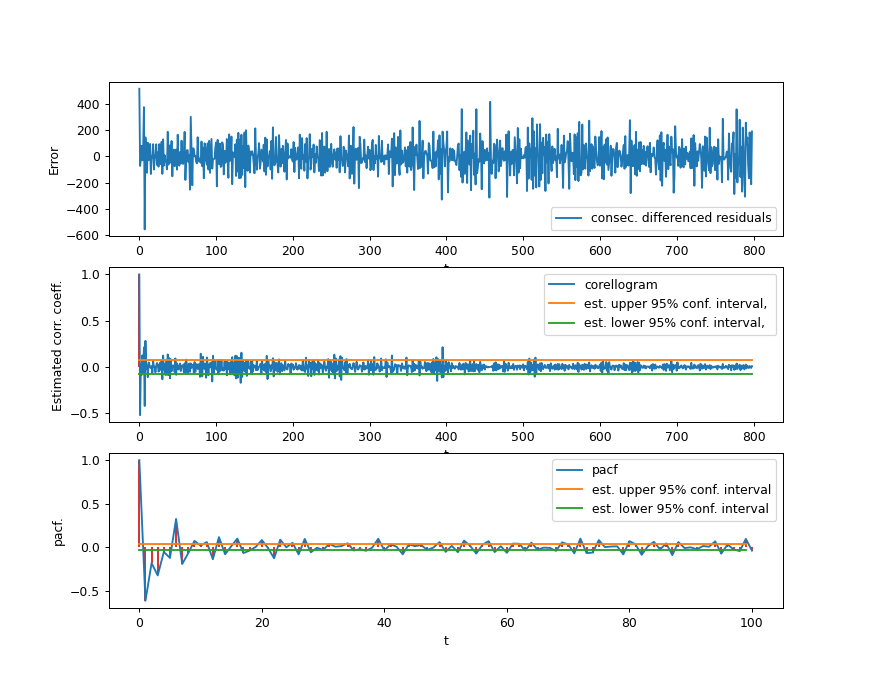

est_p_poly: None
est_q_poly: Poly(-0.826443168737105*B**365 - 0.722346668207602*B**30 - 0.181965739843832*B**7 - 0.137747439710724*B + 1.0, B, domain='RR')


In [11]:
p_poly = None
q_poly = poly(1 - (a * B) - (b * B ** 7) - (c * B ** 30) - (d * B ** 365), B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B ** 365, B) * poly(1 - B ** 30, B)

p_symbols = []
q_symbols = [a, b, c, d]

res = spp.learn_model(ts_cut_year_week_month_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=100)
plt.show()

The autocorr. is far from an MA(1) process. Whilst the 365th lag has been muted, there are spikes at lag 1,7-1,7,7+1,365+30.
    
And for our last model (just for studying), we will remove the monthly param, and yearly param.

### Model 2 w/o monthly param: SMA_7(1)xMA(1)

<IPython.core.display.Javascript object>


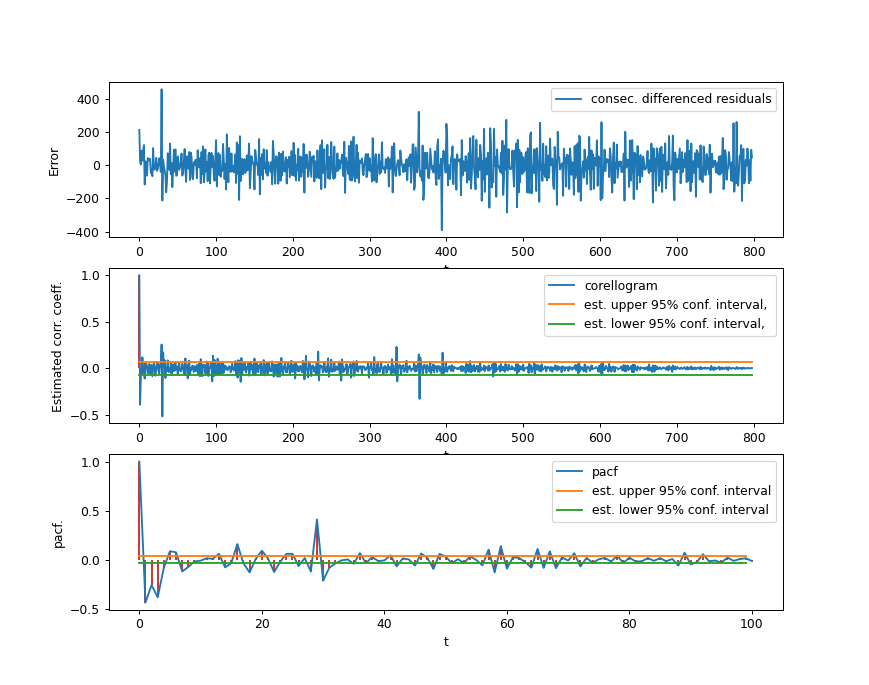

est_p_poly: None
est_q_poly: Poly(0.659195819577215*B**8 - 0.847051750018278*B**7 - 0.77822378569313*B + 1.0, B, domain='RR')


In [12]:
p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B) * poly(1 - B ** 365, B) * poly(1 - B ** 30, B)

p_symbols = []
q_symbols = [a, b]

res = spp.learn_model(ts_cut_year_week_month_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

create_residuals_subplots(ts_cut, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=100)
plt.show()

The process is far from an MA(1), due to having spikes at lag 30, and 365 and also at (30-1,30+1), and (365-30,365+30).
From earlier, seeing that removing the yearly differencing yields better results than introducing a yearly parameter, it
is perhaps the case that we have overdifferenced and that the monthly SMA parameter is excessive.

## Forecasting

We now proceed to forecasting our results. Let us relearn our parameters using the first 2 years of data, and use the remaining 70 days (due to discluding the CoVid intervention period) to test our forecasting capabilities.

Based on our findings above, Model 1 w/o the yearly differencing seems adequate for studying, but we have already given concern as to why in reality it is probably non-optimal. In fact, we have only learnt later that the time series extending earlier than 2018 is available. This is for future work however: (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).

est_q_poly: Poly(0.537940278967865*B**8 - 0.798770098314285*B**7 - 0.673460711790699*B + 1.0, B, domain='RR')


<IPython.core.display.Javascript object>


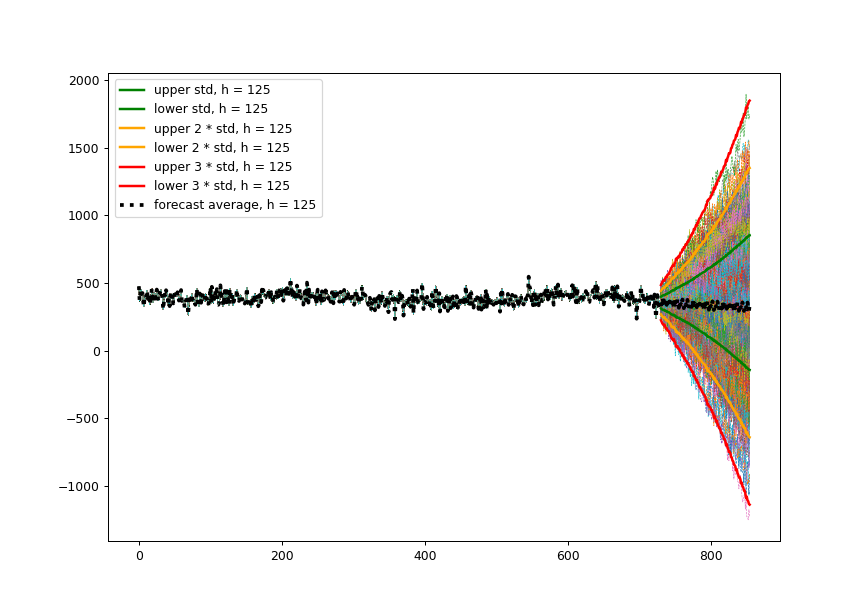

In [13]:
ts_cut = series_data[:(2 * 365)]
ts_cross_val = series_data[2 * 365:(2 * 365) + 70]
ts_cut_week = ts_cut[:-week] - ts_cut[week:]
ts_cut_week_sec = ts_cut_week[:-1] - ts_cut_week[1:]

p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 7, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 7, B)

p_symbols = []
q_symbols = [a, b]

res_main = spp.learn_model(ts_cut_week_sec, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res_main.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

N = len(ts_cut)
h_max = 125  # forecast length

est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)
print("est_q_poly:", est_q_poly)

a_t = spp.calculateSeasonalARIMA_error(ts_cut.astype(float), None, d_poly, est_q_poly)
yt_forecasts = spp.forecastSeasonalARIMA(ts_cut.astype(float), a_t, h_max, None, d_poly, est_q_poly)

y_multiforecasts, y_stds, y_means = spp.batch_forecastSeasonalARIMA(ts_cut.astype(float), a_t, h_max, None, d_poly,
                                                                        est_q_poly, num_samples=500)

fig, ax = plt.subplots(1)

for i in range(y_multiforecasts.shape[0]):
    ax.plot(y_multiforecasts[i], linewidth=0.5, linestyle='--')

yt_forecast_initial_val = ts_cut[-1]
N = len(ts_cut)
forecast_len = len(y_stds) - N
forecast_interval = np.arange(N, N + forecast_len)
y_stds = y_stds[-forecast_len:]   #take only the y_stds beyond the series length
ax.plot(forecast_interval, yt_forecast_initial_val + y_stds, label='upper std, h = ' + str(h_max), linewidth=2,
        color='green')
ax.plot(forecast_interval, yt_forecast_initial_val - y_stds, label='lower std, h = ' + str(h_max), linewidth=2,
        color='green')

ax.plot(forecast_interval, yt_forecast_initial_val + 2 * y_stds, label='upper 2 * std, h = ' + str(h_max),
        linewidth=2,
        color='orange')
ax.plot(forecast_interval, yt_forecast_initial_val - 2 * y_stds, label='lower 2 * std, h = ' + str(h_max),
        linewidth=2,
        color='orange')

ax.plot(forecast_interval, yt_forecast_initial_val + 3 * y_stds, label='upper 3 * std, h = ' + str(h_max),
        linewidth=2, color='red')
ax.plot(forecast_interval, yt_forecast_initial_val - 3 * y_stds, label='lower 3 * std, h = ' + str(h_max),
        linewidth=2, color='red')

ax.plot(yt_forecasts, label='forecast average, h = ' + str(h_max), linewidth=3, linestyle=':', color='black')

plt.legend()
plt.show()

In the image above, the black line indicates the forecast. The forecast begins beyond the 730th day. The black line represents the average forecast of the model. We have also sampled the forecasts by sampling (normal) random errors. These forecasts are shown by the small frayed lines in the plot that overlap each other. Their standard deviations are computed and plotted, as well as twice and thrice of the stds. 

Studying the forecast, the model appears inadequate for long term forecasting (around 1 year of forecasting). We see that the forecast has a slight trend downwards. Also a caveat we have with the way we have implemented the model, is that the model may forecast negative no. of incidents. This is an artefact of the model and ofcourse is not realistic.

Let us see what happens if we are only required to forecast a week ahead, and additionally that we receive fresh data weekly as well.

<IPython.core.display.Javascript object>


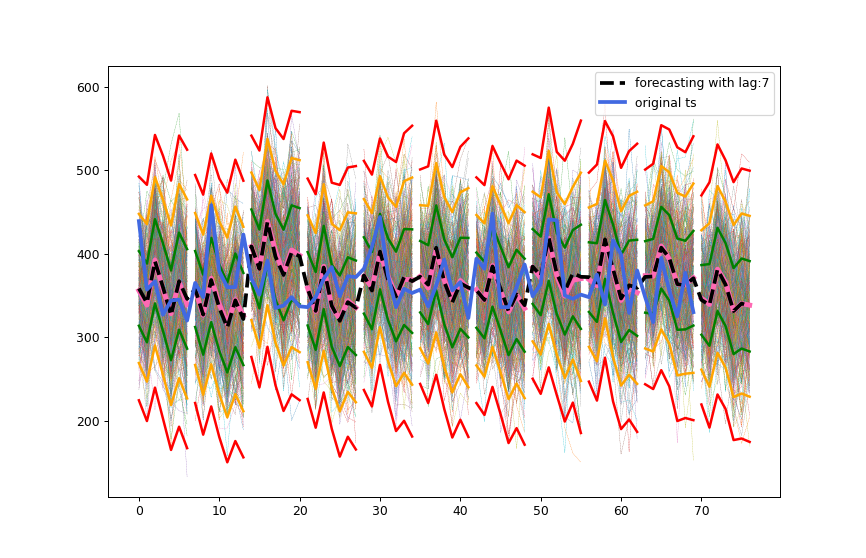

In [14]:
h = 7
y_h_pieces = spp.stepwise_forecastSeasonalARIMA(ts_cut.astype(float), h, None, d_poly, est_q_poly, ts_cross_val)

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    ts_cut.astype(float), h, None,
    d_poly, est_q_poly, ts_cross_val,
    num_samples=400)

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green', linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red', linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red', linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=4)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(ts_cross_val, label='original ts', color='royalblue', linewidth=3)
plt.legend()
plt.show()

In the image, above, the green lines are the estimated first standard deviation interval, the orange are 2 * std intervals, and the red are 3 * std intervals. The frayed lines above are actual forecast samples, and therefore captures somewhat the forecast likelihood distribution. The pink line is the mean of such samples, whilst the green,orange and red lines are multiples of the std of these samples.

Note that the black line is also the average forecast of the model and was determined analytically. Therefore, the average of the samples (pink) and the forecast (black) should theoretically coincide. 

Looking at the results, it appears that whilst the forecasts are mostly within the first standard deviation interval (green intervals), the expected daily forecasts are not very good. Thus, from a practical usage viewpoint, the intervals appear to be a better tool for operational research or planning. The orange curves whilst strongly captures the interval, may not be very useful.

Rather than assuming that errors are normally distributed, we may choose to approximate the distribution via a kernel density estimate (kde)  and use it for sampling forecasts:

<IPython.core.display.Javascript object>


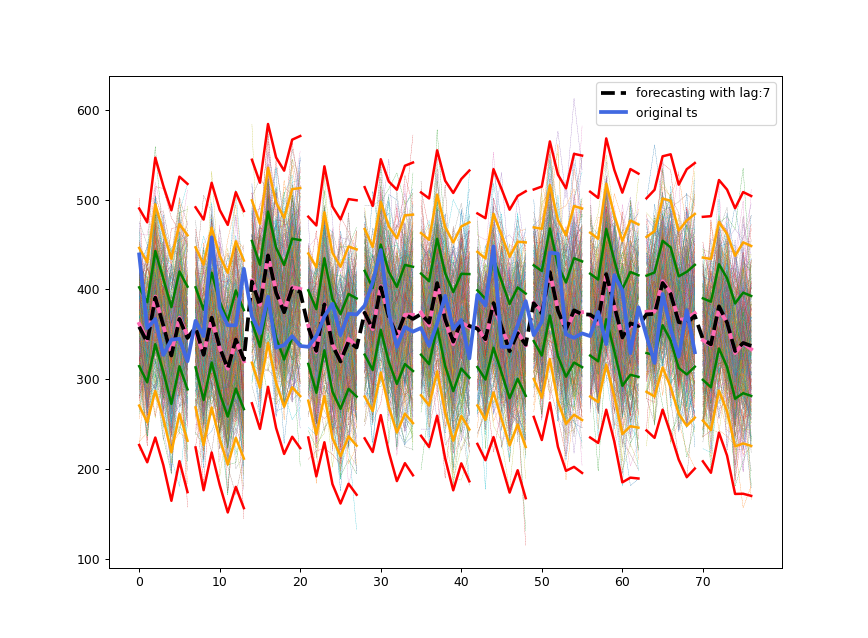

In [15]:
h = 7
y_h_pieces = spp.stepwise_forecastSeasonalARIMA(ts_cut.astype(float), h, None, d_poly, est_q_poly,
                                                ts_cross_val)

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    ts_cut.astype(float), h, None,
    d_poly, est_q_poly, ts_cross_val,
    num_samples=400)

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red',
            linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=3)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(ts_cross_val, label='original ts', color='royalblue', linewidth=3)
ax.legend()
plt.show()

It does not appear to change our intervals by much, although it appears to be slightly tighter.

Let us see what happens if we change the update of new data to every 2 days instead of weekly (7):

<IPython.core.display.Javascript object>


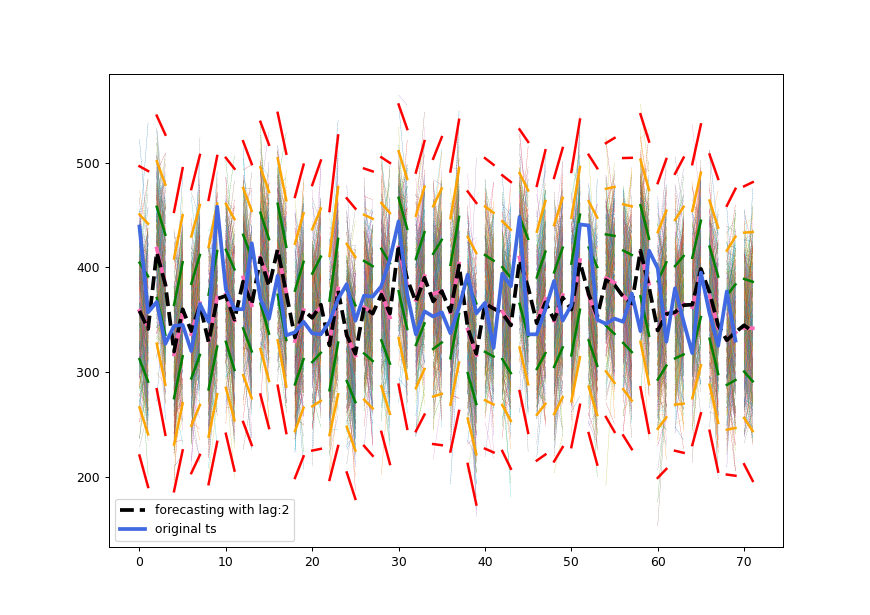

In [16]:
h = 2
y_h_pieces = spp.stepwise_forecastSeasonalARIMA(ts_cut.astype(float), h, None, d_poly, est_q_poly, ts_cross_val,
                                                sample_errors=False, use_a_t_kde=False)

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    ts_cut.astype(float), h, None,
    d_poly, est_q_poly, ts_cross_val,
    num_samples=400)

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red',
            linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=3)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(ts_cross_val, label='original ts', color='royalblue', linewidth=3)
ax.legend()
plt.show()

Again, the daily estimates are poor. But the first std approximate is not bad.

## Summary and future work

We have experimented with a few different models, with the initial few being taken from the earlier exploratory analysis. We were not able to incorporate the yearly seasonal into our model, even it's existence appears reasonable. There was not much evidence for a monthly seasonal either. Thus, at this point in time we chose Model 1 w/o the yearly differencing, to attempt forecasting.

We attempted both long-term and short-term forecasting. We found that long-term forecasting was unsound, whilst short-term forecasting seems capable, however only in terms of confidence intervals. This is due to the fact that the daily forecasts appears to be quite poor.

For future work, one should try exponential smoothing (Holt-Winters) to see if the results are better, but more importantly to see if the parameters are reliable by trying older data: (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).